# Semester Project - Continuous time paradigm in Digital Signal Processing investigation

Continuous-Time Digital Signal Processing is a signal processing paradigm that allows the discretization of a signal, working only by means of amplitude quantization. The discrete signal remains continuous in time in the digital domain, allowing a number of advantages from a digital processing point of view, such as removed aliasing phenomena and reduction of quantization error. It has been shown how this method can be achieved with “event-driven” control systems using level-crossing sampling, amplitude quantization and input signal decomposition.

This notebook contains the complete analysis done throughout the semester, following these main steps:

1. **Continuous time simulation with oversampling**: a simulation of continuous time signals with an oversampling approach and comparison of the spectral effects of quantization only and quantization+sampling
2. **Simulation of an Amplitude Sampler**
3. **Theoretical quantization approach**: following the derivation present in the article
4. **Binary wave and FIR reconstruction**




⚠️Before starting⚠️
Make sure you have installed all the following packages and you have all the necessary Python files contained in the repository!

In [135]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

from scipy import signal, fft
from scipy.optimize import brentq
from scipy.signal import find_peaks


In [146]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex
from functions import amplitude_sampler

In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Continuous time simulation with oversampling

In oder to show the effect of combined quantizatio and sampling on arbitrary signal, one must first try recreate a signal that is close to continuos time as possible.
The easiest, yet not highly efficient way to do this, is to oversample the signal with an extrimely high sampling frequency.

Let's try this first with an easy signal: a sinusoidal wave.
We start by defining the time vector given a finite duration and the choosen sampling frequency

In [138]:
# frequency settings
f_wave = 1000 # Hz
fsmp_ct = 120000
fsmp_1 = 44100;
# duration
n_periods = 1000;
duration= n_periods*1/f_wave
xlimit = 2/f_wave

In [139]:
print("Frequency of the sinusoid: ", f_wave, "Hz")
print("Period of the sinusoid: ", 1/f_wave, "s")
print("Over-Sampling frequency: ", fsmp_ct, "Hz")
print("Duration of the sinusoid: ", duration, "s")

Frequency of the sinusoid:  1000 Hz
Period of the sinusoid:  0.001 s
Over-Sampling frequency:  120000 Hz
Duration of the sinusoid:  1.0 s


In [140]:
# continuous time wave
t_ct = functions.time_vector(fsmp_ct, duration)
s = signals_ex(t_ct, f_wave)
x_ct = s.cosine(amp = 0.8)

# sampled wave
t_smp1 = functions.time_vector(fsmp_1, duration) # continuous time vector
s = signals_ex(t_smp1, f_wave)
x_smp1= s.cosine(amp = 0.8)

print("Length of continuous time signal : ", len(t_ct), len(x_ct))
print("Length of sampled signal: ", len(t_smp1), len(x_smp1))

Length of continuous time signal :  120000 120000
Length of sampled signal:  44100 44100


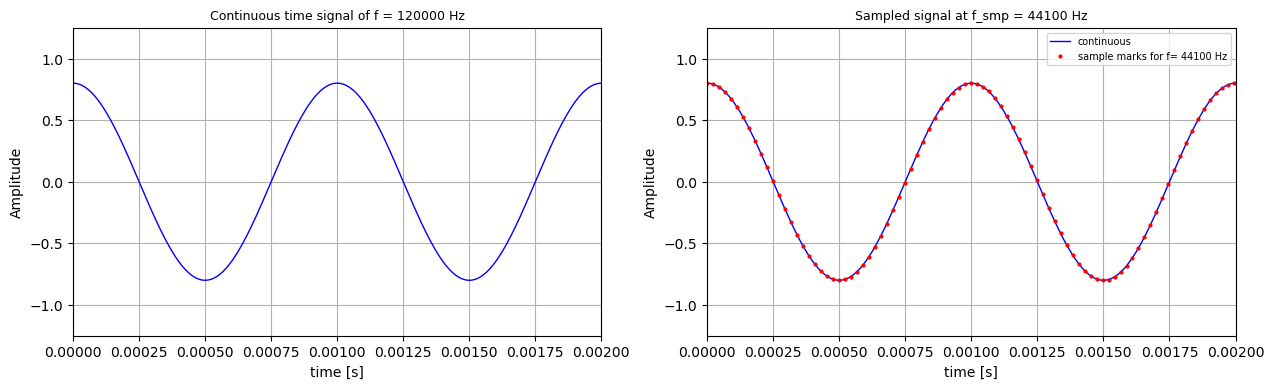

In [141]:
fig = plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous signal', col='b')
plt.title('Continuous time signal of f = %d Hz' %(fsmp_ct),fontsize = 9)

plt.subplot(1,2,2)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='continuous', col= 'b')
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fsmp_1))
plt.title('Sampled signal at f_smp = %d Hz' %(fsmp_1),fontsize = 9)
plt.legend(prop={'size': 7})

#### Quantization of CT signal


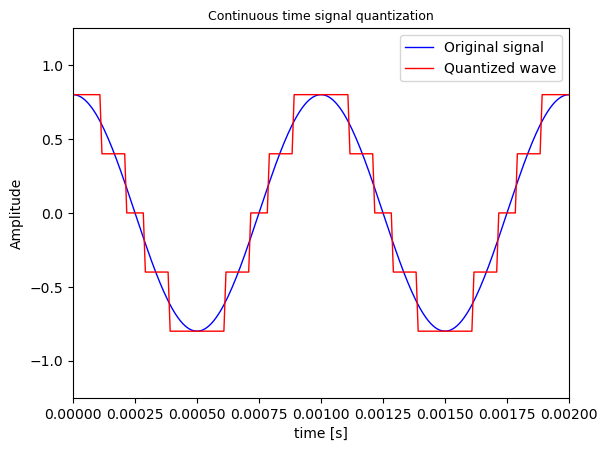

In [142]:
q = functions.quantizer(5)
x_q = q.quantize(x_ct)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_ct, x_q, xlimit, ylim=1.25,label='Quantized wave',col='r' )
plt.title('Continuous time signal quantization',fontsize = 9)
plt.legend()

#### Quantization + sampling

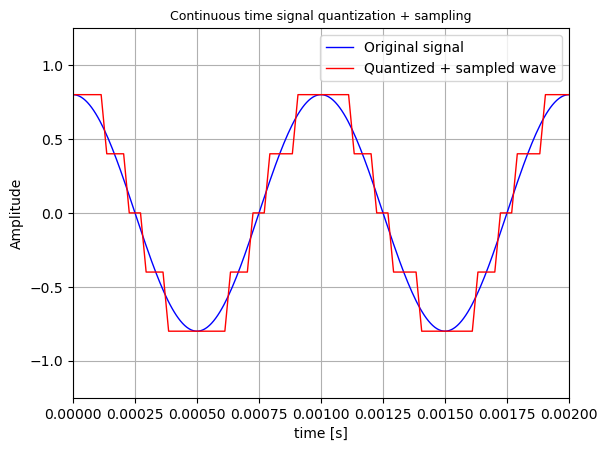

In [143]:
q = functions.quantizer(5)
x_q_smp1 = q.quantize(x_smp1)
utils.plot_wave(t_ct, x_ct, xlimit, ylim=1.25,label='Original signal', col='b')
utils.plot_wave(t_smp1, x_q_smp1, xlimit, ylim=1.25,label='Quantized + sampled wave',col='r' )
plt.title('Continuous time signal quantization + sampling',fontsize = 9)
plt.grid()
plt.legend()


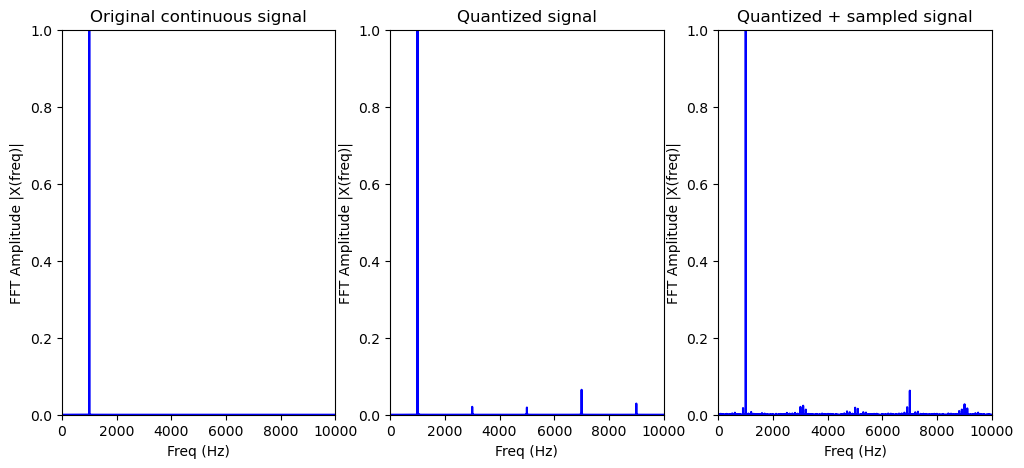

In [144]:
freq_ct, X_ct = utils.fourier_analysis(x_ct, fsmp_ct)
freq_q, X_q = utils.fourier_analysis(x_q, fsmp_ct)
freq_q_smp1, X_q_smp1 = utils.fourier_analysis(q.quantize(x_smp1), fsmp_1)

plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot(freq_ct, X_ct, freq_lim=10000, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot(freq_q, X_q, freq_lim=10000, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot(freq_q_smp1, X_q_smp1, freq_lim=10000, title="Quantized + sampled signal")

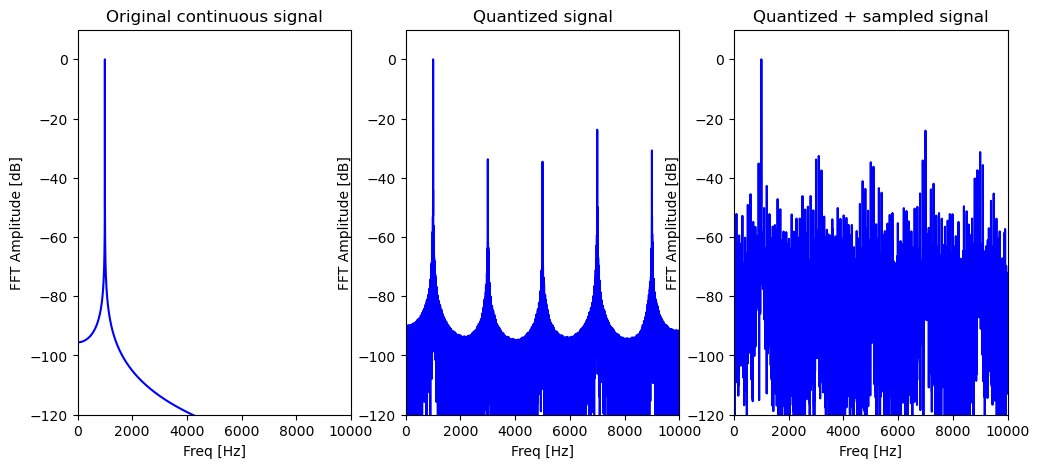

In [145]:
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
utils.fourier_plot_db(freq_ct, X_ct, freq_lim=10000, ylim=-120, title="Original continuous signal")
plt.subplot(1,3,2)
utils.fourier_plot_db(freq_q, X_q, freq_lim=10000, ylim= -120, title="Quantized signal")
plt.subplot(1,3,3)
utils.fourier_plot_db(freq_q_smp1, X_q_smp1, freq_lim=10000, ylim=-120,title="Quantized + sampled signal")

## 2. Amplitude sampler
The oversampling method is helpful to visulized the spectral effects of sampling on a quantized signal, but it is a very computationally heavy task. The higher the frequency of our signal is, the higher the sampling frequency will have to be in order to first satisfy the nyquist criterion, and secondly to achieve a sufficient number of points to mimic the continuous time behaviour, i.e. a smooth and continuous curve.

**explain the problem with time precision of the crossing instants even with high oversampling**

In this section, we explore a new method that does not involve oversampling, but it is purely based on the principle of amplitude sampling. This is not only helpful for the matter of computational costs, but it is also very efficient as it is similar to an event-based process.


**Explain amplitude sampler**

In [165]:
T = 1
t_range = np.linspace(0,T,1000)
q = functions.quantizer(5)

# transitions and bins
t, q_idx = amplitude_sampler(functions.test_func, T, q)
bin_step = q.qvalue(q_idx) #find the step value of each bin

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))
print('Bins step value: {}'.format(bin_step))

Transition instants: [0.         0.02972127 0.09678314 0.31988353 0.3869454  0.44638794
 0.5134498  0.7365502  0.80361206 0.8630546  0.93011647]
Bins index: [2 3 4 3 2 1 0 1 2 3 4]
Bins step value: [ 0.   0.4  0.8  0.4  0.  -0.4 -0.8 -0.4  0.   0.4  0.8]


The following tests show that the transition points are indipendent of the initial density of the grid. As long as the grid is not too sparse, we are able to obtain the crossing instants efficiently with fewer points

In [161]:
print(" 10000 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=10000)[0][0:5]))
print(" 100 points per period grid: {}".format(amplitude_sampler(functions.test_func, T, q, gd=100)[0][0:5]))

 10000 points per period grid: [0.         0.02972127 0.09678314 0.31988353 0.3869454 ]
 100 points per period grid: [0.         0.02972127 0.09678314 0.31988353 0.3869454 ]
crossing more than one level


In [162]:
try:
    amplitude_sampler(functions.test_func, T, q, gd=10)[0]
except AssertionError:
    print('crossing more than one level')

crossing more than one level


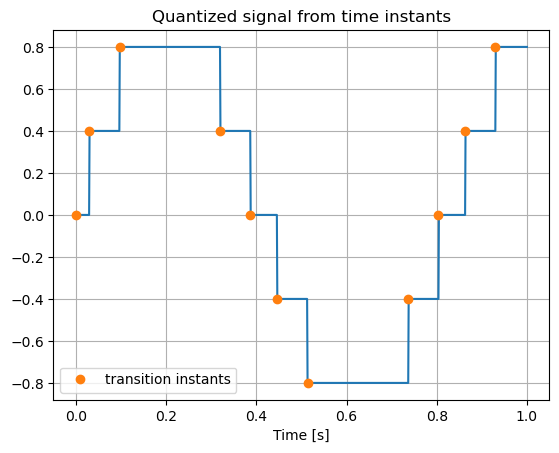

In [174]:
pulse_times = functions.decompose(t, q_idx, T)
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
plt.plot(t, bin_step, 'o', label='transition instants')
plt.title("Quantized signal from time instants")
plt.xlabel("Time [s]")
plt.legend()
plt.grid()

The decomposition into pulses and building of the quantized signal can also be done by means of an analytical **Fourier series** .

In [176]:
def FS(n, t0,t1, T, x, delta):
    F=0
    for i in range(1,n):
        c = 1/(np.pi*i) * (np.exp(-1j*2*np.pi*i/T*(t0+t1)/2)*np.sin(2*np.pi*i/T*(t1-t0)/2))
        F_tmp  = delta * c*np.exp(1j*2*np.pi*i*x/T)
        F = F + F_tmp
    return F

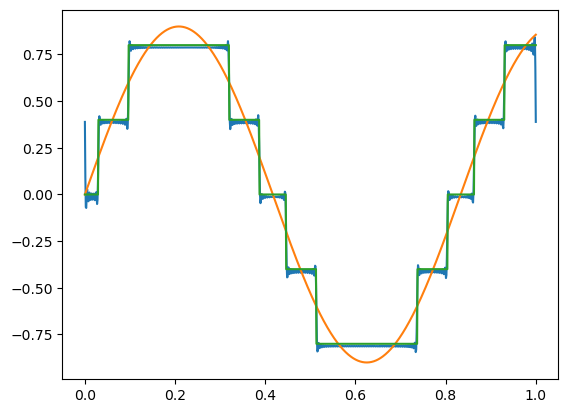

In [188]:
FS_complete = 0
x = np.linspace(0, T, 1000) #time vector
pulse_times= functions.decompose(t, q_idx, T)

for i in range(len(pulse_times)):
    F_tmp = FS(200, pulse_times[i][0], pulse_times[i][1],T, x, q.step*2)
    FS_complete = FS_complete + F_tmp

plt.plot(x, FS_complete + 0.07)
plt.plot(x, functions.test_func(x))
functions.plot_decomposition(functions.decompose(t, q_idx, T), q)
